### text-cnn
paper:
- [Convolutional Neural Networks for Sentence Classification | Kim Yoon](https://arxiv.org/abs/1408.5882)

code reference (pre-process):
- https://www.kaggle.com/eliotbarr/text-classification-using-neural-networks
- https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/NLP_word_vectors_classification_rendered.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test_no_answer.csv')
df_train

,row_id,TEXT,LABEL
0,0,good to know if you can t find these elsewhere .,1
1,1,love it ! the grill plates come out and pop i...,1
2,2,i m convinced this was a poorly executed refur...,0
3,3,i would never have complained about that if it...,0
4,4,"the photo shows the same whole , large candie...",0
...,...,...,...
10995,10995,i didn t quite get it the first time .,1
10996,10996,i ve tried installing with and without the oem...,0
10997,10997,i was parked at a truck stop in the cincinnati...,0
10998,10998,i recently bought this case after seeing some ...,1


### Preprocessing text for the (supervised) CBOW model
The following cells uses Keras to preprocess text:

- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the 20000 most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
- we convert the output classes as 1-hot encodings

In [3]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = df_train['TEXT'].astype(str)
texts_test = df_test['TEXT'].astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9872 unique tokens.


In [4]:
pprint(sequences[0])
pprint(df_train['TEXT'].loc[0])

[46, 6, 170, 37, 17, 33, 19, 195, 35, 856]
'good to know if you can t find these elsewhere .'


In [5]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 9872)

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):


In [6]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [7]:
# try to invert sequences[0] origin sentence
" ".join([index_to_word[i] for i in sequences[0]])

'good to know if you can t find these elsewhere'

#### Let's have a closer look at the tokenized sequences:

average length: 13.5
max length: 25


(array([  10.,  767.,  977., 1017., 1018., 1009.,  987.,  917.,  884.,
           0.,  837.,  762.,  728.,  708.,  277.,   78.,   18.,    4.,
           0.,    2.]),
 array([ 7. ,  7.9,  8.8,  9.7, 10.6, 11.5, 12.4, 13.3, 14.2, 15.1, 16. ,
        16.9, 17.8, 18.7, 19.6, 20.5, 21.4, 22.3, 23.2, 24.1, 25. ]),
 <a list of 20 Patch objects>)

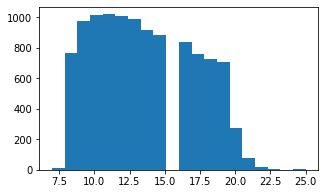

In [8]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
plt.figure(figsize=(5,3))
plt.hist(seq_lens, bins=20)

### Prepare train/test sequences

In [9]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

MAX_SEQUENCE_LENGTH = 50

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (11000, 50)
Shape of data test tensor: (2000, 50)


In [10]:
y_train = to_categorical(np.asarray(df_train['LABEL'])) # has label as answer
y_test = df_test['LABEL'] # no label
print('Shape of label tensor:', y_train.shape)
print('Shape of label test tensor:', y_test.shape)

Shape of label tensor: (11000, 2)
Shape of label test tensor: (2000,)


### Model 1 : A simple supervised CBOW model in Keras
- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 2 classes (+ softmax)

In [11]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# embedding layer
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# pooling
average = GlobalAveragePooling1D()(embedded_sequences)
# dropout = Dropout(0.5)(average)

# softmax
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 1,000,102
Trainable params: 1,000,102
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train, y_train, validation_split=0.2, # how to split??
          epochs=15, batch_size=128)

C:\Users\Weber\.conda\envs\testAI\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8800 samples, validate on 2200 samples
Epoch 1/15
8800/8800 [==============================] - 2s 174us/step - loss: 0.6912 - acc: 0.5384 - val_loss: 0.6884 - val_acc: 0.5668
Epoch 2/15
8800/8800 [==============================] - 1s 141us/step - loss: 0.6816 - acc: 0.7091 - val_loss: 0.6776 - val_acc: 0.6745
Epoch 3/15
8800/8800 [==============================] - 1s 142us/step - loss: 0.6622 - acc: 0.7223 - val_loss: 0.6582 - val_acc: 0.6873
Epoch 4/15
8800/8800 [==============================] - 1s 134us/step - loss: 0.6319 - acc: 0.7533 - val_loss: 0.6337 - val_acc: 0.6918
Epoch 5/15
8800/8800 [==============================] - 1s 139us/step - loss: 0.5950 - acc: 0.7674 - val_loss: 0.6086 - val_acc: 0.7077
Epoch 6/15
8800/8800 [==============================] - 1s 140us/step - loss: 0.5578 - acc: 0.7824 - val_loss: 0.5873 - val_acc: 0.7105
Epoch 7/15
8800/8800 [==============================] - 1s 138us/step - loss: 0.5233 - acc: 0.7983 - val_loss: 0.5689 - val_acc: 0.7227


- origin: acc: 0.9657 - val_loss: 0.5980 - val_acc: 0.7836 (15 epoch)
- with dropout: acc: 0.9415 - val_loss: 0.6207 - val_acc: 0.7386 (30 epoch)

ploting reference :https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


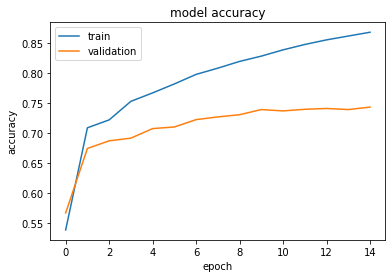

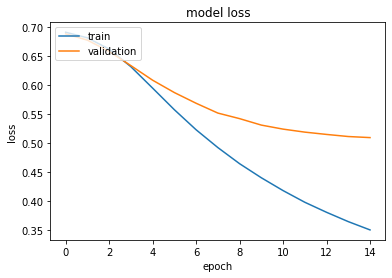

In [14]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### make submission
must convert probability predictions into categories (class label) first  
code reference: [Get class labels from Keras functional model](https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model)

In [15]:
output_test = model.predict(x_test)
print(output_test[:5])
print(output_test.shape)

[[0.6063306  0.39366937]
 [0.6654529  0.3345471 ]
 [0.5249732  0.47502673]
 [0.93570924 0.06429076]
 [0.55276173 0.4472383 ]]
(2000, 2)


In [17]:
y_classes = output_test[0].argmax(axis=-1)
y_classes

0

In [20]:
submission = {
    'row_id': list(range(0,len(output_test))),
    'LABEL': [x.argmax(axis=-1) for x in output_test]
}
submission = pd.DataFrame.from_dict(submission)
submission.head(5)

,row_id,LABEL
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [21]:
submission['LABEL'].value_counts()

0    1251
1     749
Name: LABEL, dtype: int64

In [22]:
submission.to_csv('submission/sub_CBOW.csv', index=False)